# Tensor Version

In [ ]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow.keras import layers

In [ ]:
(train_images,_),(_,_) = tf.keras.datasets.fashion_mnist.load_data()

train_images.shape

4422102/4422102 [==============================] - 1s 0us/step


(60000, 28, 28)

In [ ]:
train_images = train_images.reshape(train_images.shape[0],28,28,1).astype('float32')

train_images.shape

(60000, 28, 28, 1)

In [ ]:
train_images[3000,2,2,0]


0.0

In [ ]:
train_images = (train_images -127.5)/127.5

train_images[3000,:5,:5]

array([[[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]],

       [[-1.],
        [-1.],
        [-1.],
        [-1.],
        [-1.]]], dtype=float32)

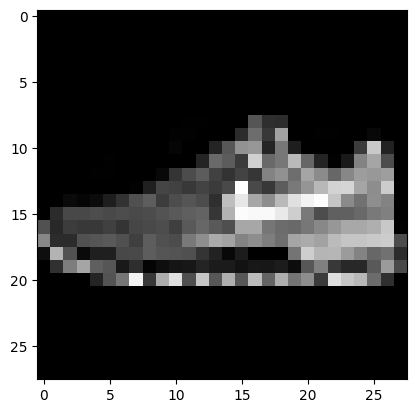

In [ ]:
plt.imshow(train_images[2567].squeeze(),cmap='gray')

In [ ]:
buffer_size =60000
batch_size = 128

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [ ]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(64,input_dim = 100))
  model.add(layers.ReLU())

  model.add(layers.Dense(128))
  model.add(layers.ReLU())

  model.add(layers.Dense(784,activation='tanh'))
  model.add(layers.Reshape((28,28,1)))

  return model

In [ ]:
generator = generator_model()

generator.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 re_lu_1 (ReLU)              (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 115,920
Trainable params: 115,920
Non-trai

In [ ]:
noise = tf.random.normal([1,100])
generated_image = generator(noise,training =False)

generated_image.shape


TensorShape([1, 28, 28, 1])

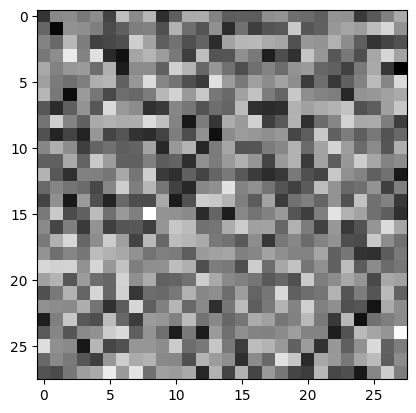

In [ ]:
plt.imshow(generated_image[0,:,:,0],cmap = 'gray')

In [ ]:
def discriminator_model():
  model =tf.keras.Sequential()
  model.add(layers.Input(shape=(28,28,1)))
  model.add(layers.Flatten())

  model.add(layers.Dense(256))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.5))

  model.add(layers.Dense(128))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(64))
  model.add(layers.LeakyReLU(0.2))
  model.add(layers.Dropout(0.2))

  model.add(layers.Dense(1,activation='sigmoid'))
  return model

In [ ]:
discriminator = discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)              

In [ ]:
discriminator = discriminator_model()
output = discriminator(generated_image)
print(output)

tf.Tensor([[0.4139199]], shape=(1, 1), dtype=float32)


In [ ]:
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
def discriminator_loss(real_output,fake_output):
  real_loss = bce(tf.ones_like(real_output),real_output)

  fake_loss = bce(tf.zeros_like(fake_output),fake_output)

  total_loss = real_loss + fake_loss

  return total_loss

In [ ]:
def generator_loss(fake_output):
  gen_loss = bce(tf.ones_like(fake_output),fake_output)
  return gen_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

In [ ]:
checkpoint_dir = '.training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir,'chk')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,discriminator_optimizer = discriminator_optimizer, generator = generator, discriminator=discriminator)

Start Training

In [ ]:
epochs = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate,noise_dim])


In [ ]:
@tf.function
def train_step(images):
  noise = tf.random.normal([batch_size,noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise,training = True)

    real_output = discriminator(images,training = True)
    fake_output = discriminator(generated_images,training = True)

    disc_loss = discriminator_loss(real_output,fake_output)
    gen_loss = generator_loss(fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))

  return (gen_loss,disc_loss,tf.reduce_mean(real_output),tf.reduce_mean(fake_output))


In [ ]:
def generator_and_plot_images(model,epoch,test_input):
  predictions = model(test_input,training = False)

  fig = plt.figure(figsize = (8,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    pred = (predictions[i,:,:,0]+1)*127.5
    pred = np.array(pred)
    plt.imshow(pred.astype(np.uint8),cmap = 'gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset,epochs):
  gen_loss_list =[]
  disc_loss_list =[]

  real_score_list = []
  fake_score_list = []

  for epoch in tqdm(range(epochs)):
    start = time.time()
    num_batches = len(dataset)

    print(f'Training started with epoch {epoch + 1} with {num_batches} batches ...')

    total_gen_loss = 0
    total_disc_loss = 0

    for batch in dataset:
      generator_loss,discriminator_loss,real_score,fake_score = train_step(batch)
      total_gen_loss += generator_loss
      total_disc_loss += discriminator_loss


    mean_gen_loss = total_gen_loss / num_batches
    mean_disc_loss = total_disc_loss / num_batches

    print('Losses after epoch %5d: generator %.3f, discriminator %.3f, real score %.2f%%, fake score %.2f%%' %
          (epoch + 1, generator_loss, discriminator_loss , real_score*100, fake_score*100))

    generator_and_plot_images(generator,epoch + 1 ,seed)

    gen_loss_list.append(mean_gen_loss)
    disc_loss_list.append(mean_disc_loss)
    real_score_list.append(real_score)
    fake_score_list.append(fake_score)

    if (epoch + 1 )  % 10 == 0:
      checkpoint.save(file_prefix= checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1 ,time.time() - start))

  return gen_loss_list,disc_loss_list, real_score_list, fake_score_list

  0%|          | 0/50 [00:00<?, ?it/s]

Training started with epoch 1 with 469 batches ...
Losses after epoch     1: generator 8.847, discriminator 0.164, real score 98.40%, fake score 7.16%


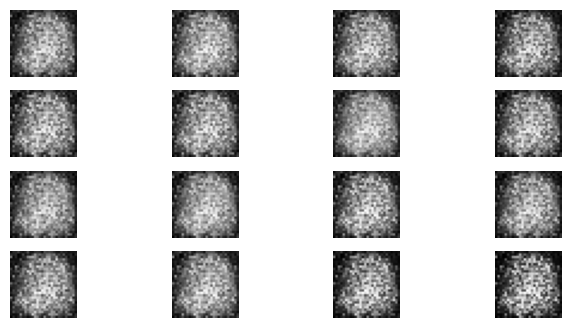

  2%|▏         | 1/50 [00:08<06:39,  8.15s/it]

Time for epoch 1 is 8.145187854766846 sec
Training started with epoch 2 with 469 batches ...
Losses after epoch     2: generator 10.130, discriminator 0.174, real score 97.69%, fake score 2.33%


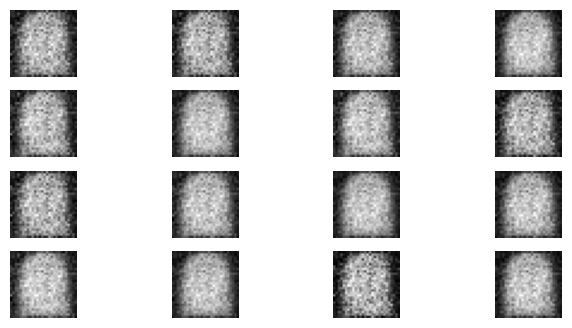

  4%|▍         | 2/50 [00:10<04:00,  5.02s/it]

Time for epoch 2 is 2.8230113983154297 sec
Training started with epoch 3 with 469 batches ...
Losses after epoch     3: generator 6.212, discriminator 0.028, real score 99.05%, fake score 1.51%


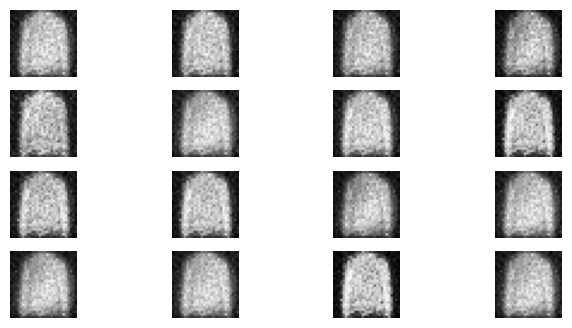

  6%|▌         | 3/50 [00:13<02:59,  3.83s/it]

Time for epoch 3 is 2.4067299365997314 sec
Training started with epoch 4 with 469 batches ...
Losses after epoch     4: generator 3.742, discriminator 0.168, real score 95.38%, fake score 6.58%


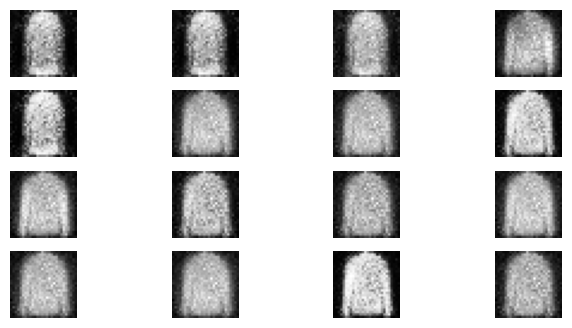

  8%|▊         | 4/50 [00:15<02:28,  3.24s/it]

Time for epoch 4 is 2.3284521102905273 sec
Training started with epoch 5 with 469 batches ...
Losses after epoch     5: generator 6.415, discriminator 0.143, real score 95.74%, fake score 4.75%


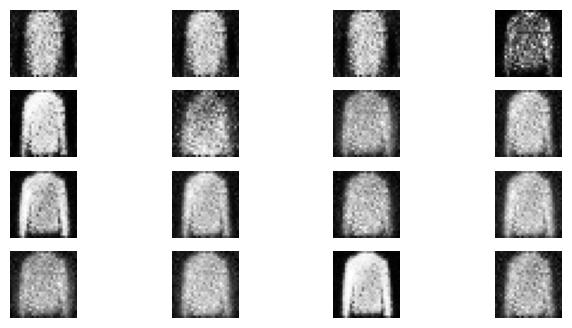

 10%|█         | 5/50 [00:18<02:11,  2.92s/it]

Time for epoch 5 is 2.348220109939575 sec
Training started with epoch 6 with 469 batches ...
Losses after epoch     6: generator 4.099, discriminator 0.187, real score 99.22%, fake score 8.81%


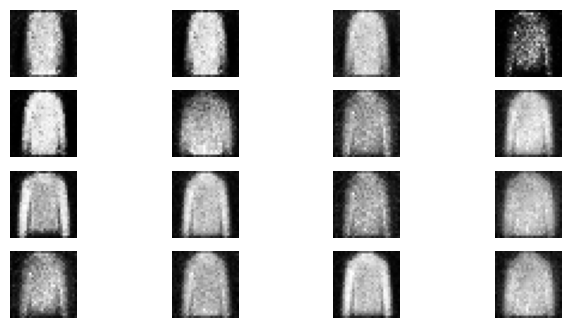

 12%|█▏        | 6/50 [00:21<02:10,  2.97s/it]

Time for epoch 6 is 3.0778751373291016 sec
Training started with epoch 7 with 469 batches ...
Losses after epoch     7: generator 5.170, discriminator 0.157, real score 95.13%, fake score 5.07%


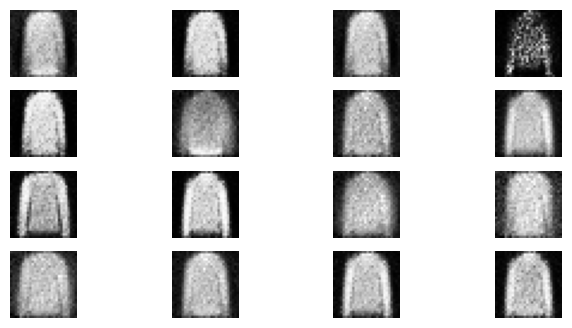

 14%|█▍        | 7/50 [00:23<02:00,  2.80s/it]

Time for epoch 7 is 2.4466419219970703 sec
Training started with epoch 8 with 469 batches ...
Losses after epoch     8: generator 6.059, discriminator 0.302, real score 95.37%, fake score 7.48%


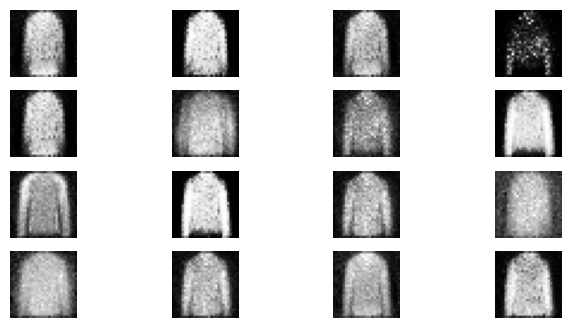

 16%|█▌        | 8/50 [00:25<01:51,  2.66s/it]

Time for epoch 8 is 2.3680667877197266 sec
Training started with epoch 9 with 469 batches ...
Losses after epoch     9: generator 3.141, discriminator 0.432, real score 89.61%, fake score 14.70%


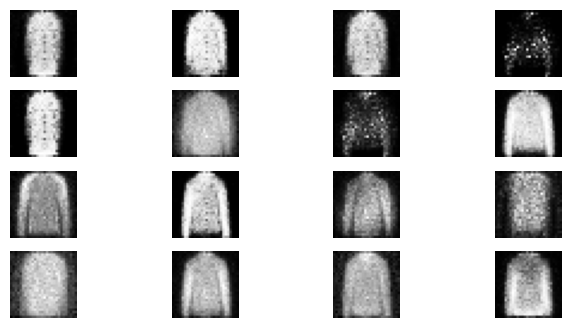

 18%|█▊        | 9/50 [00:28<01:44,  2.56s/it]

Time for epoch 9 is 2.3164634704589844 sec
Training started with epoch 10 with 469 batches ...
Losses after epoch    10: generator 3.290, discriminator 0.516, real score 86.19%, fake score 14.27%


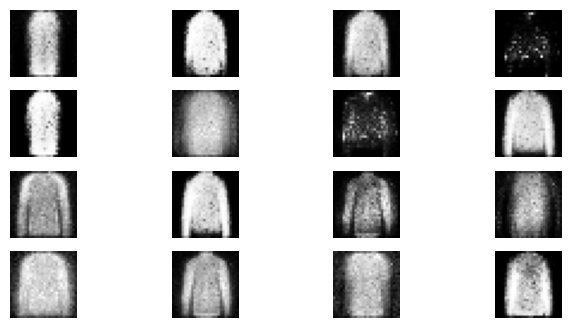

 20%|██        | 10/50 [00:31<01:44,  2.61s/it]

Time for epoch 10 is 2.717379331588745 sec
Training started with epoch 11 with 469 batches ...
Losses after epoch    11: generator 4.083, discriminator 0.327, real score 93.02%, fake score 9.30%


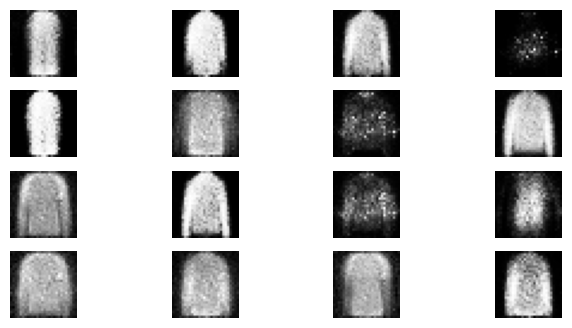

 22%|██▏       | 11/50 [00:33<01:45,  2.70s/it]

Time for epoch 11 is 2.9151675701141357 sec
Training started with epoch 12 with 469 batches ...
Losses after epoch    12: generator 2.394, discriminator 0.416, real score 87.82%, fake score 15.52%


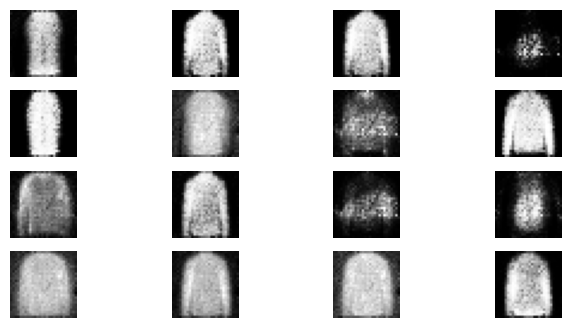

 24%|██▍       | 12/50 [00:36<01:38,  2.60s/it]

Time for epoch 12 is 2.360183000564575 sec
Training started with epoch 13 with 469 batches ...
Losses after epoch    13: generator 3.527, discriminator 0.231, real score 92.93%, fake score 9.74%


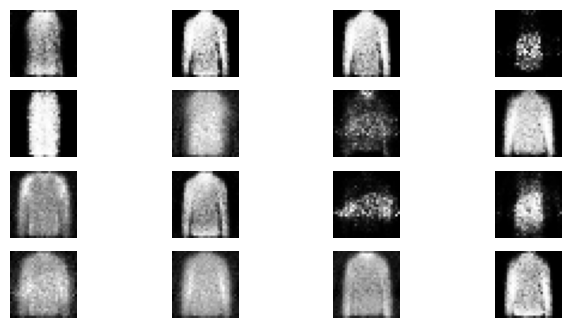

 26%|██▌       | 13/50 [00:38<01:33,  2.53s/it]

Time for epoch 13 is 2.3507378101348877 sec
Training started with epoch 14 with 469 batches ...
Losses after epoch    14: generator 3.472, discriminator 0.376, real score 88.36%, fake score 8.42%


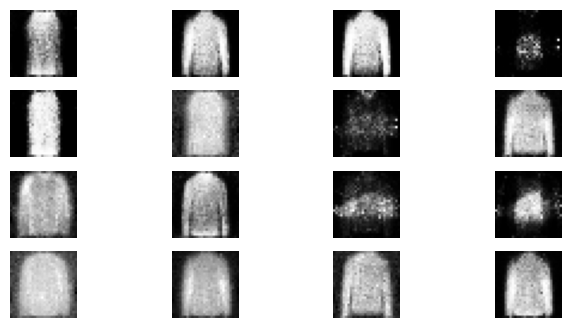

 28%|██▊       | 14/50 [00:41<01:32,  2.57s/it]

Time for epoch 14 is 2.6725456714630127 sec
Training started with epoch 15 with 469 batches ...
Losses after epoch    15: generator 2.466, discriminator 0.713, real score 83.05%, fake score 19.91%


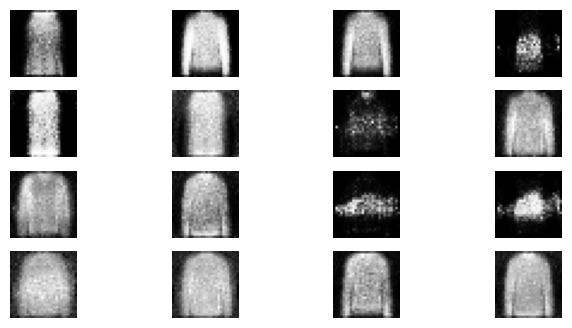

 30%|███       | 15/50 [00:43<01:28,  2.52s/it]

Time for epoch 15 is 2.4119012355804443 sec
Training started with epoch 16 with 469 batches ...
Losses after epoch    16: generator 2.438, discriminator 0.607, real score 77.12%, fake score 16.17%


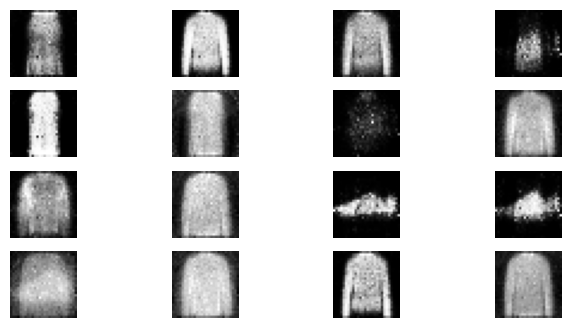

 32%|███▏      | 16/50 [00:46<01:29,  2.64s/it]

Time for epoch 16 is 2.9088287353515625 sec
Training started with epoch 17 with 469 batches ...
Losses after epoch    17: generator 2.956, discriminator 0.259, real score 93.75%, fake score 11.71%


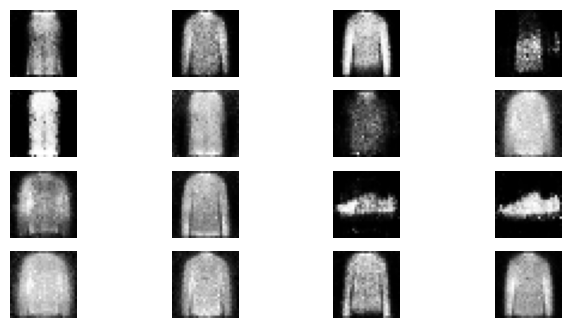

 34%|███▍      | 17/50 [00:49<01:24,  2.57s/it]

Time for epoch 17 is 2.3919153213500977 sec
Training started with epoch 18 with 469 batches ...
Losses after epoch    18: generator 3.220, discriminator 0.660, real score 81.21%, fake score 10.47%


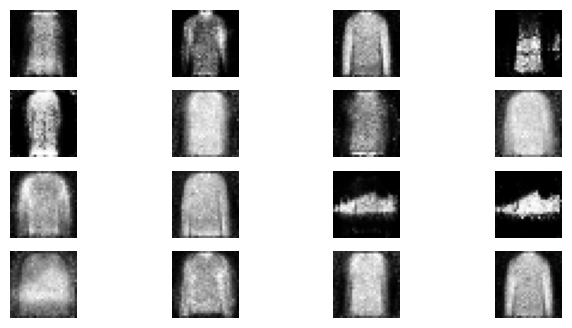

 36%|███▌      | 18/50 [00:51<01:22,  2.57s/it]

Time for epoch 18 is 2.5770187377929688 sec
Training started with epoch 19 with 469 batches ...
Losses after epoch    19: generator 3.286, discriminator 0.578, real score 81.30%, fake score 12.44%


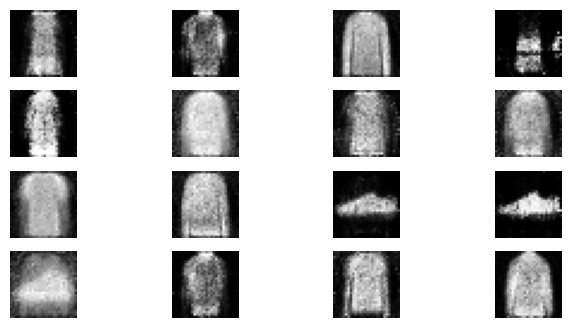

 38%|███▊      | 19/50 [00:54<01:17,  2.51s/it]

Time for epoch 19 is 2.373695135116577 sec
Training started with epoch 20 with 469 batches ...
Losses after epoch    20: generator 1.473, discriminator 0.843, real score 76.76%, fake score 30.54%


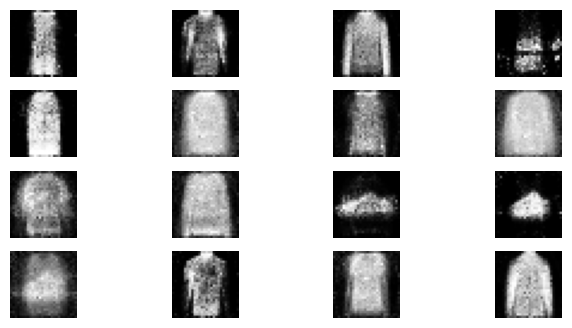

 40%|████      | 20/50 [00:56<01:17,  2.58s/it]

Time for epoch 20 is 2.714717149734497 sec
Training started with epoch 21 with 469 batches ...
Losses after epoch    21: generator 1.658, discriminator 0.922, real score 73.19%, fake score 27.05%


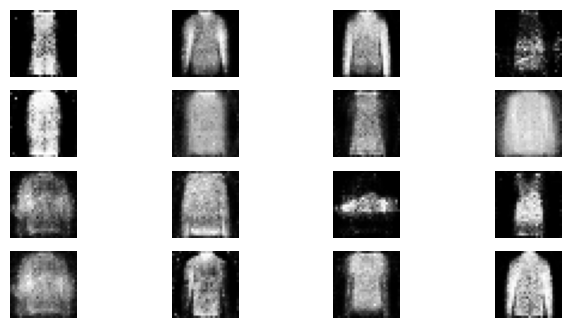

 42%|████▏     | 21/50 [00:59<01:20,  2.78s/it]

Time for epoch 21 is 3.241633176803589 sec
Training started with epoch 22 with 469 batches ...
Losses after epoch    22: generator 1.359, discriminator 0.765, real score 79.15%, fake score 31.67%


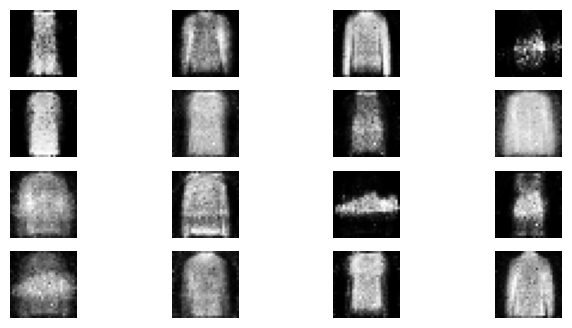

 44%|████▍     | 22/50 [01:03<01:24,  3.02s/it]

Time for epoch 22 is 3.5761194229125977 sec
Training started with epoch 23 with 469 batches ...
Losses after epoch    23: generator 1.490, discriminator 0.750, real score 73.50%, fake score 27.36%


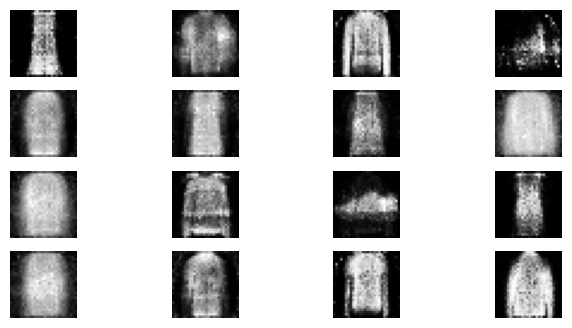

 46%|████▌     | 23/50 [01:05<01:16,  2.84s/it]

Time for epoch 23 is 2.422370195388794 sec
Training started with epoch 24 with 469 batches ...
Losses after epoch    24: generator 2.264, discriminator 0.568, real score 88.89%, fake score 19.35%


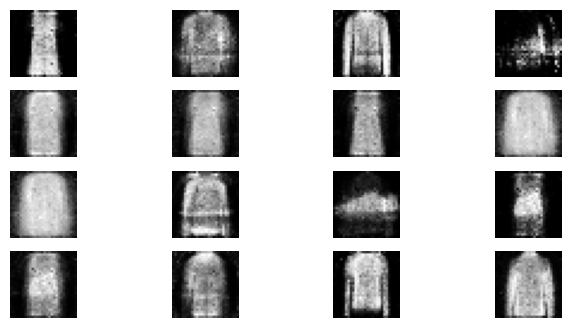

 48%|████▊     | 24/50 [01:08<01:11,  2.73s/it]

Time for epoch 24 is 2.486008882522583 sec
Training started with epoch 25 with 469 batches ...
Losses after epoch    25: generator 1.636, discriminator 0.801, real score 68.33%, fake score 25.05%


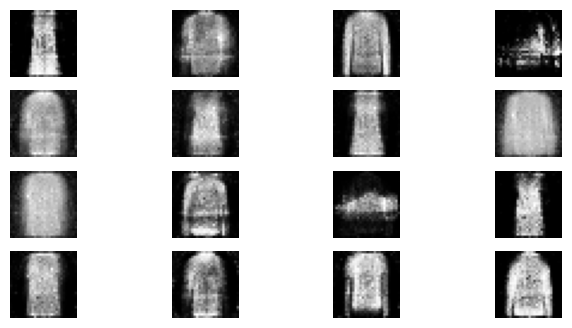

 50%|█████     | 25/50 [01:11<01:09,  2.78s/it]

Time for epoch 25 is 2.882676124572754 sec
Training started with epoch 26 with 469 batches ...
Losses after epoch    26: generator 2.098, discriminator 0.814, real score 77.67%, fake score 25.74%


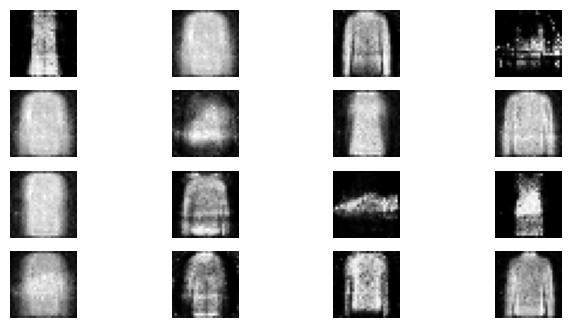

 52%|█████▏    | 26/50 [01:13<01:04,  2.69s/it]

Time for epoch 26 is 2.463587522506714 sec
Training started with epoch 27 with 469 batches ...
Losses after epoch    27: generator 2.461, discriminator 0.480, real score 82.97%, fake score 14.91%


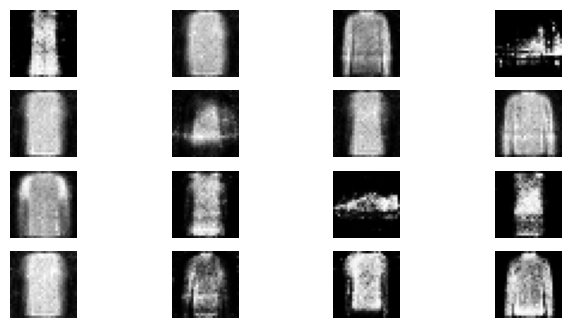

 54%|█████▍    | 27/50 [01:16<01:01,  2.66s/it]

Time for epoch 27 is 2.607785940170288 sec
Training started with epoch 28 with 469 batches ...
Losses after epoch    28: generator 2.186, discriminator 0.759, real score 79.37%, fake score 18.90%


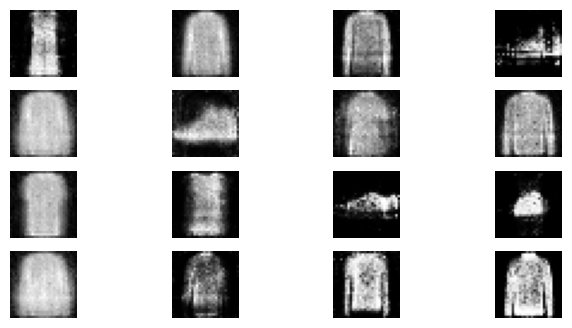

 56%|█████▌    | 28/50 [01:18<00:57,  2.60s/it]

Time for epoch 28 is 2.4424755573272705 sec
Training started with epoch 29 with 469 batches ...
Losses after epoch    29: generator 2.438, discriminator 0.625, real score 81.02%, fake score 18.16%


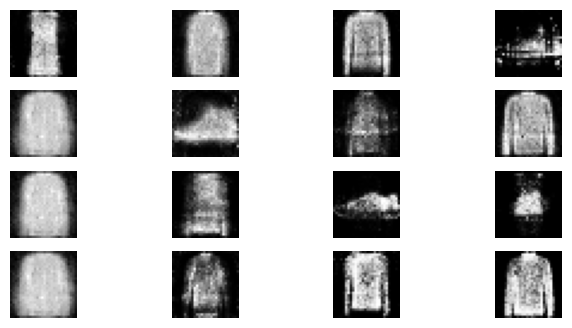

 58%|█████▊    | 29/50 [01:21<00:56,  2.68s/it]

Time for epoch 29 is 2.863633871078491 sec
Training started with epoch 30 with 469 batches ...
Losses after epoch    30: generator 2.796, discriminator 0.442, real score 85.70%, fake score 15.22%


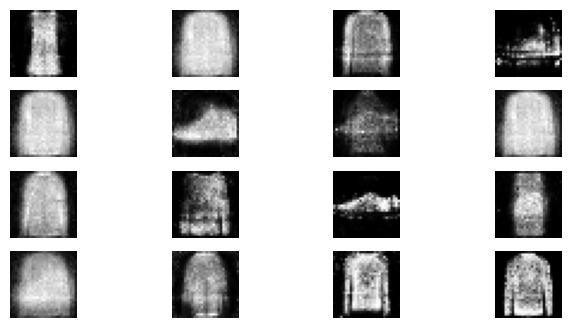

 60%|██████    | 30/50 [01:24<00:55,  2.75s/it]

Time for epoch 30 is 2.915118932723999 sec
Training started with epoch 31 with 469 batches ...
Losses after epoch    31: generator 3.272, discriminator 0.407, real score 81.06%, fake score 10.80%


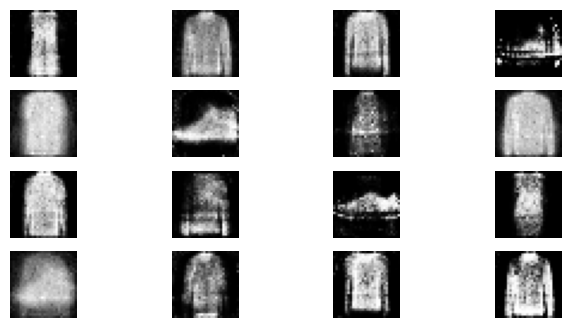

 62%|██████▏   | 31/50 [01:27<00:50,  2.64s/it]

Time for epoch 31 is 2.360917568206787 sec
Training started with epoch 32 with 469 batches ...
Losses after epoch    32: generator 1.959, discriminator 0.912, real score 72.46%, fake score 24.25%


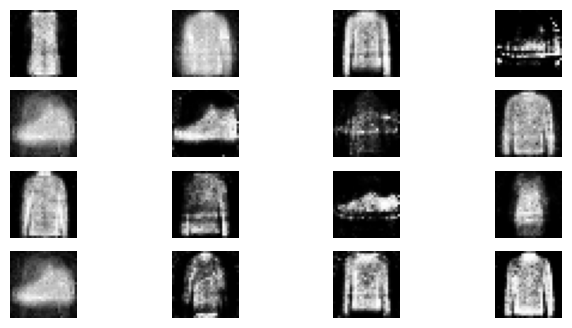

 64%|██████▍   | 32/50 [01:29<00:46,  2.56s/it]

Time for epoch 32 is 2.3866496086120605 sec
Training started with epoch 33 with 469 batches ...
Losses after epoch    33: generator 2.462, discriminator 0.467, real score 85.38%, fake score 16.68%


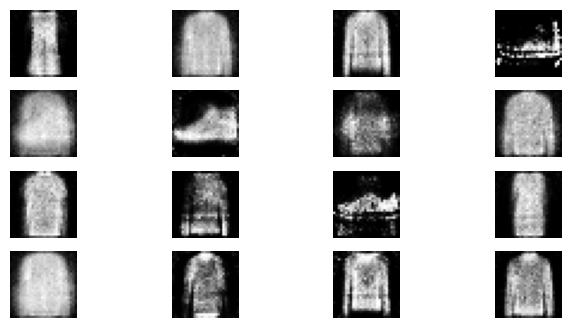

 66%|██████▌   | 33/50 [01:31<00:42,  2.51s/it]

Time for epoch 33 is 2.3675341606140137 sec
Training started with epoch 34 with 469 batches ...
Losses after epoch    34: generator 1.999, discriminator 0.853, real score 69.77%, fake score 23.09%


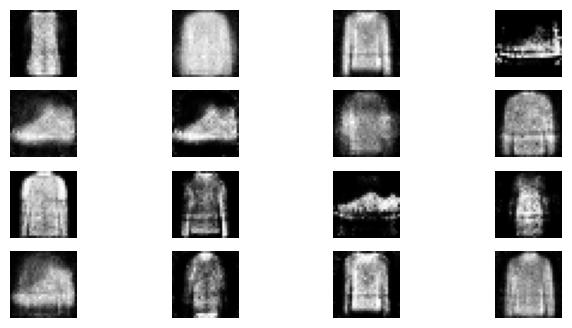

 68%|██████▊   | 34/50 [01:34<00:41,  2.62s/it]

Time for epoch 34 is 2.866964340209961 sec
Training started with epoch 35 with 469 batches ...
Losses after epoch    35: generator 1.834, discriminator 0.993, real score 71.64%, fake score 24.66%


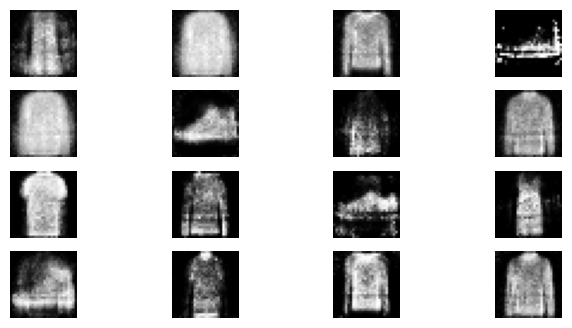

 70%|███████   | 35/50 [01:37<00:39,  2.66s/it]

Time for epoch 35 is 2.750967025756836 sec
Training started with epoch 36 with 469 batches ...
Losses after epoch    36: generator 2.254, discriminator 0.922, real score 70.78%, fake score 21.09%


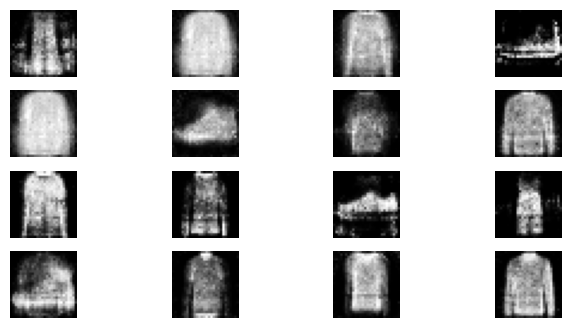

 72%|███████▏  | 36/50 [01:39<00:35,  2.56s/it]

Time for epoch 36 is 2.341564655303955 sec
Training started with epoch 37 with 469 batches ...
Losses after epoch    37: generator 1.833, discriminator 1.031, real score 80.65%, fake score 29.64%


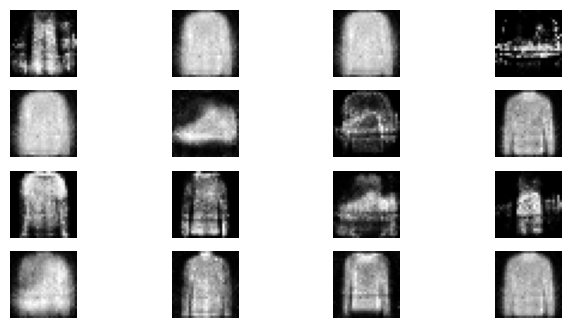

 74%|███████▍  | 37/50 [01:42<00:32,  2.51s/it]

Time for epoch 37 is 2.3839688301086426 sec
Training started with epoch 38 with 469 batches ...
Losses after epoch    38: generator 2.507, discriminator 0.456, real score 85.25%, fake score 16.93%


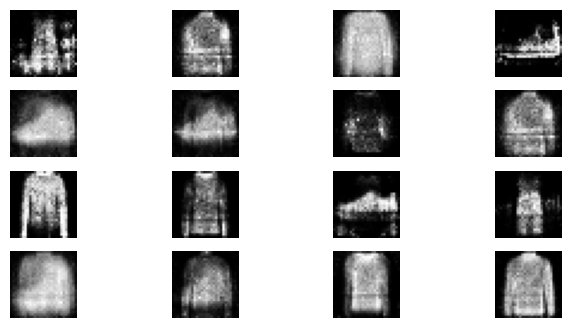

 76%|███████▌  | 38/50 [01:44<00:30,  2.57s/it]

Time for epoch 38 is 2.7014286518096924 sec
Training started with epoch 39 with 469 batches ...
Losses after epoch    39: generator 1.557, discriminator 0.939, real score 70.75%, fake score 28.49%


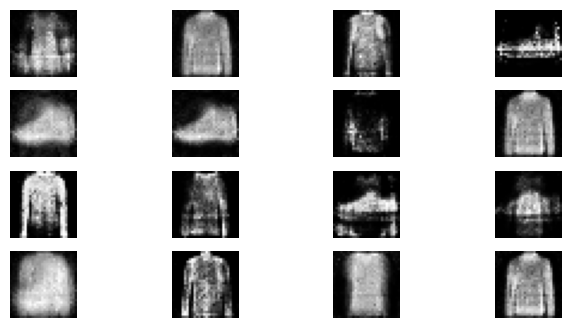

 78%|███████▊  | 39/50 [01:47<00:29,  2.67s/it]

Time for epoch 39 is 2.9023938179016113 sec
Training started with epoch 40 with 469 batches ...
Losses after epoch    40: generator 1.550, discriminator 0.860, real score 69.46%, fake score 27.79%


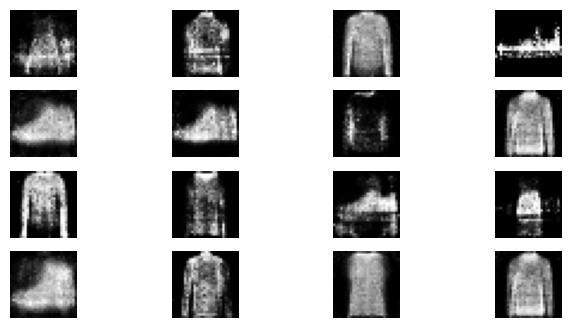

 80%|████████  | 40/50 [01:50<00:27,  2.70s/it]

Time for epoch 40 is 2.7759740352630615 sec
Training started with epoch 41 with 469 batches ...
Losses after epoch    41: generator 3.356, discriminator 0.346, real score 88.34%, fake score 11.23%


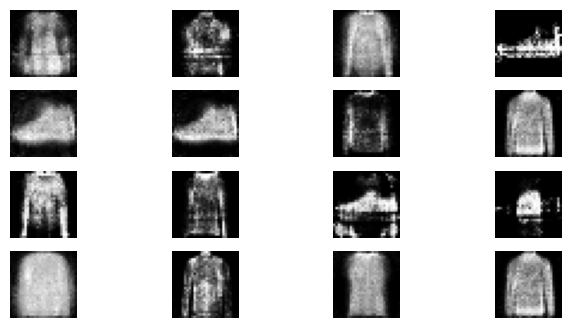

 82%|████████▏ | 41/50 [01:54<00:27,  3.06s/it]

Time for epoch 41 is 3.8696491718292236 sec
Training started with epoch 42 with 469 batches ...
Losses after epoch    42: generator 2.129, discriminator 0.730, real score 71.73%, fake score 20.94%


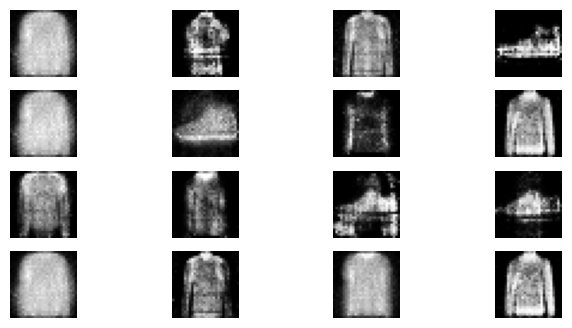

 84%|████████▍ | 42/50 [02:00<00:30,  3.81s/it]

Time for epoch 42 is 5.574247598648071 sec
Training started with epoch 43 with 469 batches ...
Losses after epoch    43: generator 2.588, discriminator 0.629, real score 84.73%, fake score 21.04%


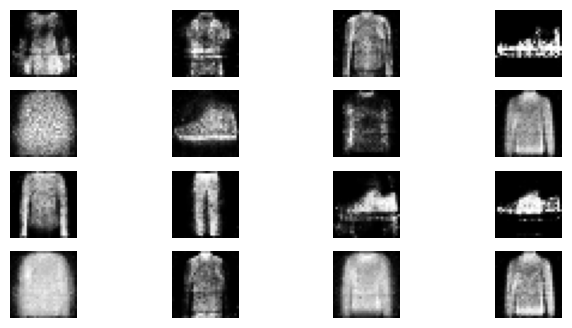

 86%|████████▌ | 43/50 [02:04<00:28,  4.04s/it]

Time for epoch 43 is 4.567383289337158 sec
Training started with epoch 44 with 469 batches ...
Losses after epoch    44: generator 2.508, discriminator 0.430, real score 84.03%, fake score 13.80%


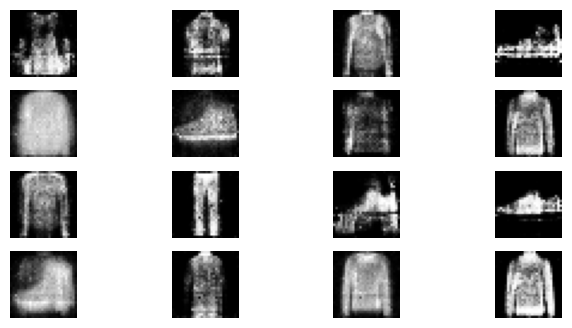

 88%|████████▊ | 44/50 [02:07<00:22,  3.67s/it]

Time for epoch 44 is 2.800874710083008 sec
Training started with epoch 45 with 469 batches ...
Losses after epoch    45: generator 2.216, discriminator 0.870, real score 75.12%, fake score 21.27%


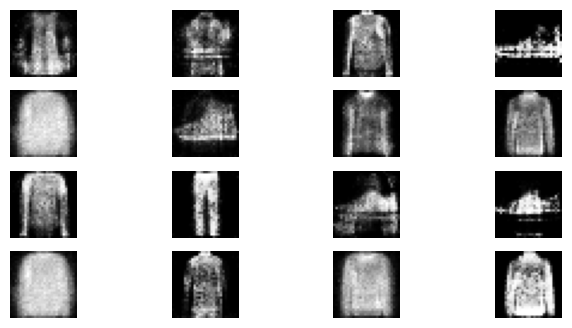

 90%|█████████ | 45/50 [02:09<00:16,  3.30s/it]

Time for epoch 45 is 2.423076868057251 sec
Training started with epoch 46 with 469 batches ...
Losses after epoch    46: generator 1.615, discriminator 1.076, real score 70.78%, fake score 32.57%


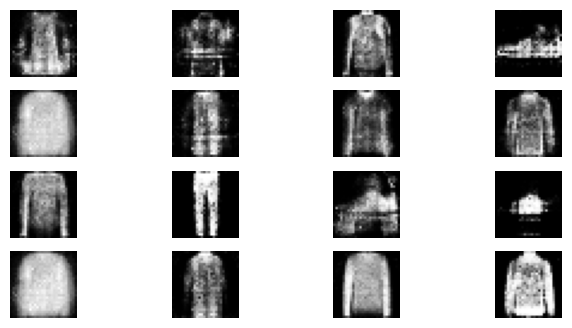

 92%|█████████▏| 46/50 [02:12<00:13,  3.25s/it]

Time for epoch 46 is 3.1434414386749268 sec
Training started with epoch 47 with 469 batches ...
Losses after epoch    47: generator 3.252, discriminator 0.394, real score 87.07%, fake score 11.31%


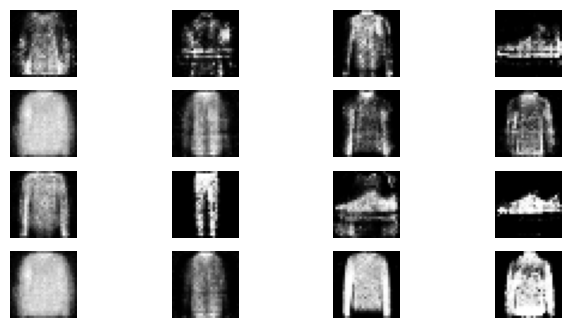

 94%|█████████▍| 47/50 [02:15<00:09,  3.03s/it]

Time for epoch 47 is 2.493574380874634 sec
Training started with epoch 48 with 469 batches ...
Losses after epoch    48: generator 2.041, discriminator 1.174, real score 67.82%, fake score 29.99%


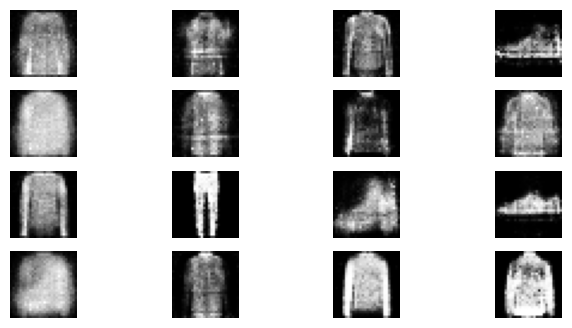

 96%|█████████▌| 48/50 [02:17<00:05,  2.86s/it]

Time for epoch 48 is 2.45375919342041 sec
Training started with epoch 49 with 469 batches ...
Losses after epoch    49: generator 3.053, discriminator 0.451, real score 82.38%, fake score 11.46%


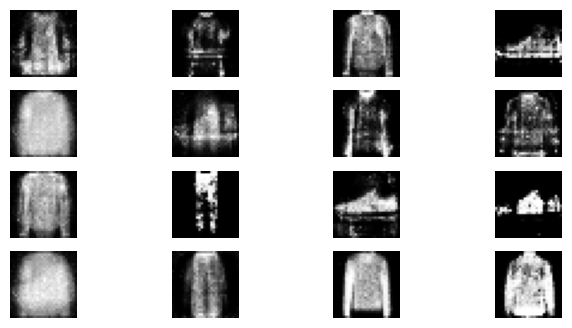

 98%|█████████▊| 49/50 [02:20<00:02,  2.73s/it]

Time for epoch 49 is 2.415856122970581 sec
Training started with epoch 50 with 469 batches ...
Losses after epoch    50: generator 2.179, discriminator 0.811, real score 74.88%, fake score 23.33%


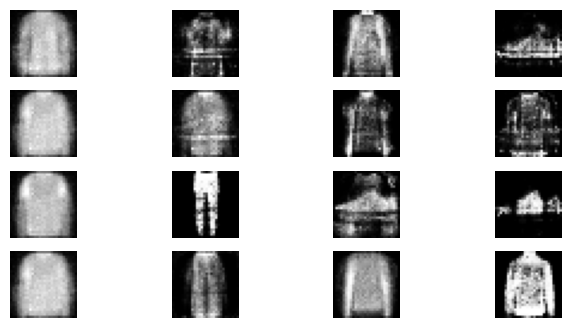

100%|██████████| 50/50 [02:23<00:00,  2.87s/it]

Time for epoch 50 is 3.0861682891845703 sec


In [ ]:
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(train_dataset ,epochs = epochs)

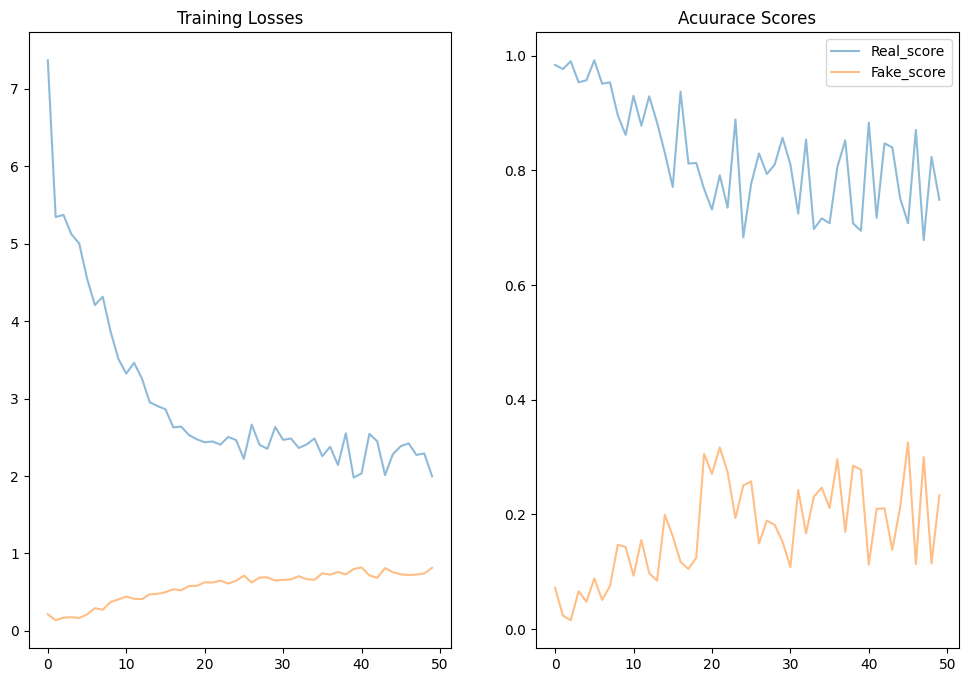

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (12,8))

ax1.plot(gen_loss_epochs, label ='Generator_loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.set_title('Training Losses')

ax2.plot(real_score_list, label ='Real_score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake_score', alpha = 0.5)
ax2.set_title('Acuurace Scores')

ax2.legend()

# Pytorch version

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = 'samples'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
#                                      std=(0.5, 0.5, 0.5))])
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../../data/',
                                   train=True,
                                   transform=transform,
                                   download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

# Generator
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

# Device setting
D = D.to(device)
G = G.to(device)

# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))

    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')